# Load libraries

In [ ]:
%load_ext autoreload
%autoreload 2


# Basic libraries
import pandas as pd
import numpy as np
import sys


# Scipy
import scipy
from scipy import signal
from scipy.linalg import solve
from scipy import constants
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq

# Locate files
import os
from pathlib import Path
from glob import glob

# Plots
from matplotlib import pyplot as plt

#Important!! Make sure your current directory is the MHDTurbPy folder!
os.chdir("/Users/nokni/work/MHDTurbPy")


# Make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data
from joblib import Parallel, delayed

""" Import manual functions """

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
import Figures as figs

from   SEA import SEA
import three_D_funcs as threeD
import download_data as download

sys.path.insert(1, os.path.join(os.getcwd(), 'functions/3d_anis_analysis_toolboox'))
import collect_wave_coeffs 
import data_analysis 

plt.rcParams['text.usetex'] = 0




os.environ["CDF_LIB"] = "/Applications/cdf/cdf/lib"

/Users/nokni/work/MHDTurbPy/pyspedas/pyspedas/__init__.py
This unreleased version of SpacePy is not supported by the SpacePy team.


# Download  WIND data

In [ ]:
from joblib import Parallel, delayed

# If you only need to download 1 interval (dates wont matter if only_one_interval=0)

save_destination        =  f'/Users/nokni/work/MHDTurbPy/examples'


cdf_lib_path            = '/Applications/cdf/cdf/lib'            # You will need to read cdf files. You have to specify the path

#User defined parameters
credentials             =      { 'psp':{
                                           'fields': {'username': None, 'password': None},
                                           'sweap' : {'username': None, 'password': None}}}


settings                =  {
                            'Data_path'              : '/Volumes/Zesen-4TB/SPEDAS/' ,
                            'Only_1_interval'        :  True,                 # If you only want to check one interval
                            'start_date'             : '1998-11-02 00:00', 
                            'end_date'               : '1998-11-08 00:00',
                            'overwrite_files'        :  1,                     # In case you want to re-do analysis for existing files!
                            'save_all'               :  True,                  # If false it will only keep derived quants. Not timeseries
                            'sc'                     : 'WIND',                 # Choices ['PSP', SOLO, 'HELIOS_A', 'HELIOS_B', 'WIND']
                            'part_resol'             : 3,                      # Max resol of plasma data                [s]
                            'MAG_resol'              : 1,                      # Max resol og magnetic field data        [s]

                            
                            'duration'               : '10H',                  # Duration of interval (in Hours)
                            'Step'                   : '5H',                   # Move starting point by step (in Hours)
                            'estimate_derived_param' :  True,
                            'Big_Gaps'               :{
                                                        'Mag_big_gaps' : 10,   # This will return 3 dtaframes containing gaps
                                                        'Par_big_gaps' : 20,   # in the respective timeseries
                                                        'QTN_big_gaps' : 300,
                                                        
                                                        },
                                                    
                            'cut_in_small_windows'   : {'flag'    : False, 
                                                        'Step'    : '10min',
                                                        'duration': '600min'},

                            'Max_par_missing'        : 10,
                            'addit_time_around'      : 4,                       # [start_time -addit_time_around [h], end_time + addit_time_around [h]]
                            'gap_time_threshold'     : 5 ,                      # Threshold for large gaps (units of seconds)
                            'apply_hampel'           : False,                   # Use hampelfilter to despike plasma data
                            'hampel_params'          : {'w'  : 200,
                                                        'std': 3},

                            'upsample_low_freq_ts'   : 0,                    #
                            'estimate_psd_b'         : 1,                       # Estimate magentic field powes spectral density (keep false)
                            'estimate_psd_v'         : 1,                       # Estimate velocity field powes spectral density (keep false)
                            'est_PSD_components'     : 1,
                            'smooth_psd'             : False,
                            'in_rtn'                 : True,                    # RTN or spacecraft frame ( We will usually use RTN)
                            'rol_mean'               : True,                    # To estimate fluctuations of mag, vel field
                            'rol_window'             : '1H',                    # When estimating fluctuations, size of window (centered around -w/2 -w/2

                            } 



if settings['sc'] == "PSP":
    vars_2_downnload = {
                        'mag'    : None, 
                        'span'   : None,
                        'span-a' : None,
                        'spc'    : None, 
                        'qtn'    : None,
                        'ephem'  : None}

elif settings['sc'] == "SOLO":
    vars_2_downnload = {
                        'mag'    : None,
                        'swa'    : None, 
                        'rpw'    : None, # Default is 'bia-density-10-seconds', but  'bia-density' is also available and probaly interesting
                        'ephem'  : None} 
else:
    
    vars_2_downnload = None
    

save_path = Path(save_destination).joinpath(settings['sc'])



generated_interval_list = download.generate_intervals(settings['start_date'],
                                                     settings['end_date'], 
                                                     settings            = settings,
                                                     data_path           = settings['Data_path'])


# Call function
Parallel(n_jobs=1)(delayed(download.download_files)(
                                                            jj, 
                                                            generated_interval_list, 
                                                            settings, 
                                                            vars_2_downnload, 
                                                            cdf_lib_path, 
                                                            credentials, 
                                                            save_path) for jj in range(len(generated_interval_list)))


24-Apr-24 12:12:35: Generating only one interval based on the provided start and end times.
24-Apr-24 12:12:35: Start Time: 1998-11-02 00:00:00
24-Apr-24 12:12:35: End Time: 1998-11-02 20:00:00
24-Apr-24 12:12:35: Considering an interval spanning: 1998-11-02 20:00:00 to 1998-11-02 00:00:00
24-Apr-24 12:12:35: Creating new folder  /Users/nokni/work/3d_anisotropy/wind_3d_anisotropy/podesta_intervals/compare_downsampled_data/WIND/1998-11-02_00-00-00_1998-11-02_20-00-00_sc_0


Working on WIND data


24-Apr-24 12:12:37: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/spacepy/time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'



Done.
Input tstart = 1998-11-01 20:00:00+00:00, tend = 1998-11-03 00:00:00+00:00
Returned tstart = 1998-11-01 20:00:01.500000, tend = 1998-11-02 23:59:58.500000
Mag fraction missing 0.45416666666666666
failed at index 0 with error: local variable 'dfpar' referenced before assignment


Traceback (most recent call last):
  File "/Users/nokni/work/MHDTurbPy/functions/downloading_helpers/WIND.py", line 329, in LoadTimeSeriesWIND
    dfpar, dfdis,qtn_flag     = LoadTimeSeriesWind_particles(pd.Timestamp(t0),
  File "/Users/nokni/work/MHDTurbPy/functions/downloading_helpers/WIND.py", line 60, in LoadTimeSeriesWind_particles
    status, data         = cdas.get_data('WI_PM_3DP', vars, time[0], time[1])
  File "/Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/cdasws/__init__.py", line 1255, in get_data
    status_code, data_result = self.get_data_result(data_request,
  File "/Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/cdasws/__init__.py", line 855, in get_data_result
    response = self._session.post(url, data=data_request.json(),
  File "/Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/requests/sessions.py", line 577, in post
    return self.request('POST', url, data=data, json=json, **kwargs)
  File "/Users/nokni/op

[None]

# Now check downloaded interval

### (1) Locate files

In [60]:
sc        = 'WIND'
load_path =   f'/Users/nokni/work/MHDTurbPy/examples/{sc}'

finnames  = func.load_files(load_path, 'final.pkl')
gennames  = func.load_files(load_path, 'general.pkl')
signames  = func.load_files(load_path, 'sig_c_sig_r.pkl')
maggaps   = func.load_files(load_path, 'mag_gaps.pkl')

/Users/nokni/work/MHDTurbPy/examples/WIND/*/final.pkl
/Users/nokni/work/MHDTurbPy/examples/WIND/*/general.pkl
/Users/nokni/work/MHDTurbPy/examples/WIND/*/sig_c_sig_r.pkl
/Users/nokni/work/MHDTurbPy/examples/WIND/*/mag_gaps.pkl


### (2) Load files

In [61]:
N   = 0

fin      = pd.read_pickle(finnames[N])
gen      = pd.read_pickle(gennames[N])
sig      = pd.read_pickle(signames[N])
mag_gaps = pd.read_pickle(maggaps[N])

In [62]:
fin['Par']['V_resampled'].keys()

Index(['Vr', 'Vt', 'Vn', 'np_3DP', 'Tp', 'np', 'np_qtn', 'Vth'], dtype='object')

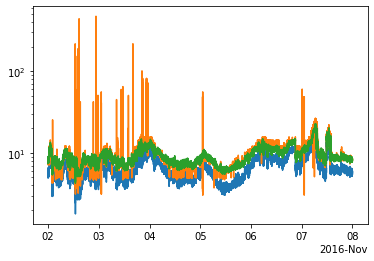

In [63]:
plt.semilogy(fin['Par']['V_resampled']['np_3DP'])
plt.semilogy(fin['Par']['V_resampled']['np_qtn'])
plt.plot(fin['Par']['V_resampled']['np'])

In [14]:

B  = fin['Mag']['B_resampled'].interpolate().dropna()

In [ ]:
lags = 1.2**np.arange(1, 90 )

r = turb.structure_functions_parallel(B[['Br', 'Bt', 'Bn']],
                                  lags,
                                  five_points_sfunc=True,
                                  return_components =True,
                                  return_Bmod=1,
                                  return_compress=1,
                                  max_qorder=5,
                                  keep_sdk=1)

In [ ]:
r

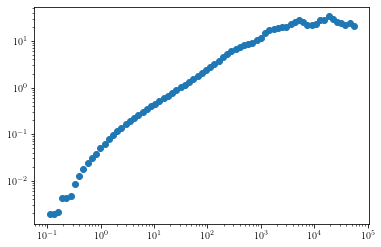

In [196]:
plt.scatter(dt*lags, r[0].T[1])

plt.yscale('log')
plt.xscale('log')

In [207]:
import numpy as np
from PyEMD import EMD
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Example signal
time = np.linspace(0, 1, 800)
signal = np.sin(2 * np.pi * 5 * time) + np.sin(2 * np.pi * 10 * time)

# 1. Decompose the signal into IMFs
emd = EMD()
IMFs = emd.emd(signal, time)

# 2. Apply the Hilbert Transform to each IMF
H_IMFs = hilbert(IMFs)

# 3. Compute instantaneous frequency and amplitude
instantaneous_phase = np.unwrap(np.angle(H_IMFs))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi) * 800
instantaneous_amplitude = np.abs(H_IMFs)

# 4. Compute and Plot Marginal Hilbert Spectrum
# For simplicity, we'll sum the amplitudes over time to approximate the marginal spectrum
marginal_spectrum = np.sum(instantaneous_amplitude[:, :-1], axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.stem(range(len(marginal_spectrum)), marginal_spectrum, 'r', markerfmt='ro', basefmt="r-")
plt.title('Marginal Hilbert Spectrum')
plt.xlabel('IMF Number')
plt.ylabel('Amplitude Sum')
plt.show()


ModuleNotFoundError: No module named 'PyEMD'

In [37]:
dt = func.find_cadence(B)

In [9]:
# sm  = func.smoothing_function(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig'])

22-Mar-24 04:21:45: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(0.001, 1440998.0756898855)

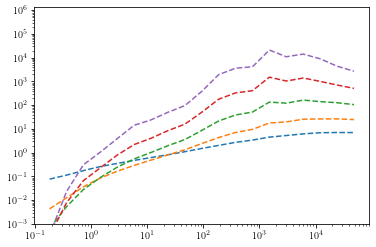

In [ ]:
for i in range(5):

    plt.loglog(dt*lags, r[0].T[i], ls='--')
    
plt.ylim([1e-3, None])

In [417]:
from scipy import constants
mu_0            = constants.mu_0  # Vacuum magnetic permeability [N A^-2]
mu0             = constants.mu_0   #
m_p             = constants.m_p    # Proton mass [kg]
kb              = constants.k      # Boltzman's constant     [j/K]
au_to_km        = 1.496e8
T_to_Gauss      = 1e4
km2m            = 1e3
nT2T            = 1e-9
cm2m            = 1e-2    

nnn = fin['Par']['V_resampled']['np'].rolling('1min', center=True).mean().interpolate()
kinet_normal    = 1e-15 / np.sqrt(mu0 * nnn.values * m_p)#.values

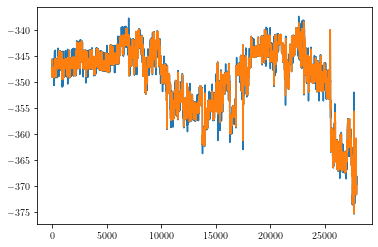

In [381]:
plt.plot(V.Vr.values[0:200000])
plt.plot(V_8.Vr.values[0:200000])

In [424]:
p    = turb.TracePSD(V.Vr.values, V.Vt.values, V.Vn.values, func.find_cadence(V))
p_12 = turb.TracePSD(V_12.Vr.values,
                  V_12.Vt.values,
                  V_12.Vn.values, 
                  func.find_cadence(V_12))
p_8  =  turb.TracePSD(V_8.Vr.values,
                  V_8.Vt.values,
                  V_8.Vn.values, 
                  func.find_cadence(V_8))
#b   = turb.TracePSD(B.Br.values, B.Bt.values, B.Bn.values, func.find_cadence(B))
b_h  = turb.TracePSD(B.Br.values, B.Bt.values, B_h.Bn.values, func.find_cadence(B_h))

In [426]:
sm      = func.smoothing_function(p[0], p[1])
sm_8    = func.smoothing_function(p_8[0], p_8[1])
sm_12   = func.smoothing_function(p_12[0], p_12[1])
sm_b    = func.smoothing_function(b_h[0], b_h[1])


In [400]:
(sm_8[1]-sm_b[1])/(sm_8[1]+sm_b[1])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3673105995.py, line 1)

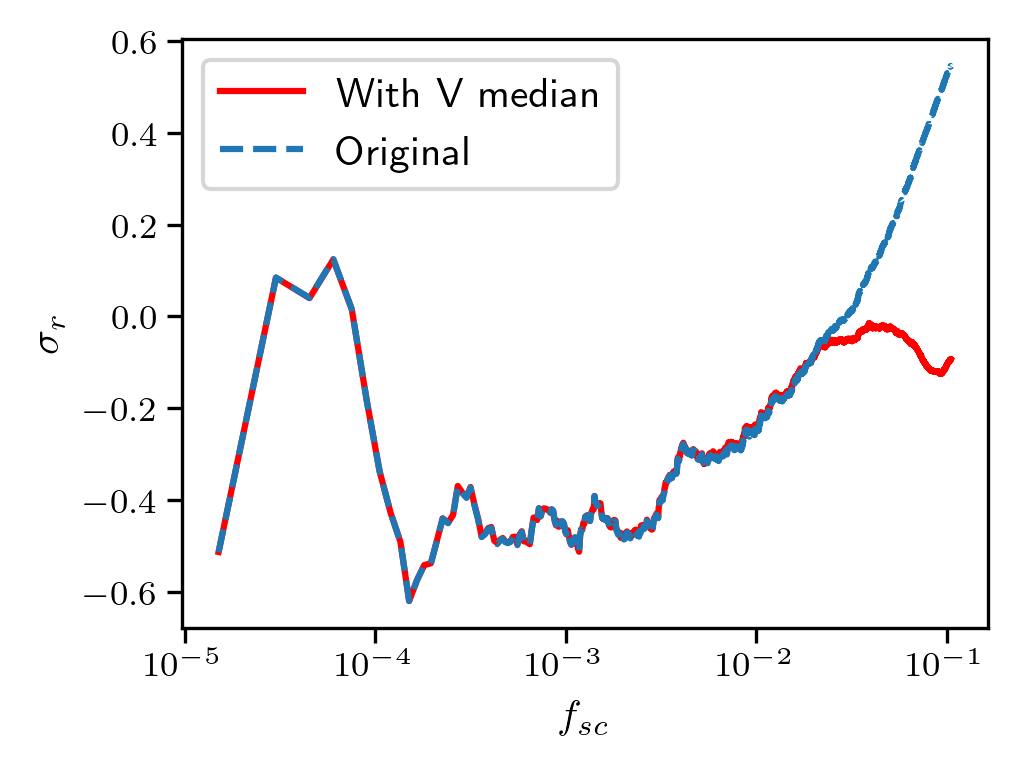

In [430]:
fig, ax =figs.initializeFigure('a', 'b')

plt.yscale('linear')
plt.semilogx(sm_8[0], (sm_8[1]-sm_b[1])/(sm_8[1]+sm_b[1]), c='r' , label ='With V median')
plt.semilogx(sm_12[0], (sm[1]-sm_b[1])/(sm[1]+sm_b[1]), c='C0', ls='--' , label ='Original')


plt.xlabel(r'$f_{sc}$')
plt.ylabel(r'$\sigma_r$')
plt.legend()

Text(0, 0.5, '$PSD ~[km^{2} s^{-2} hz^{-1} ]$')

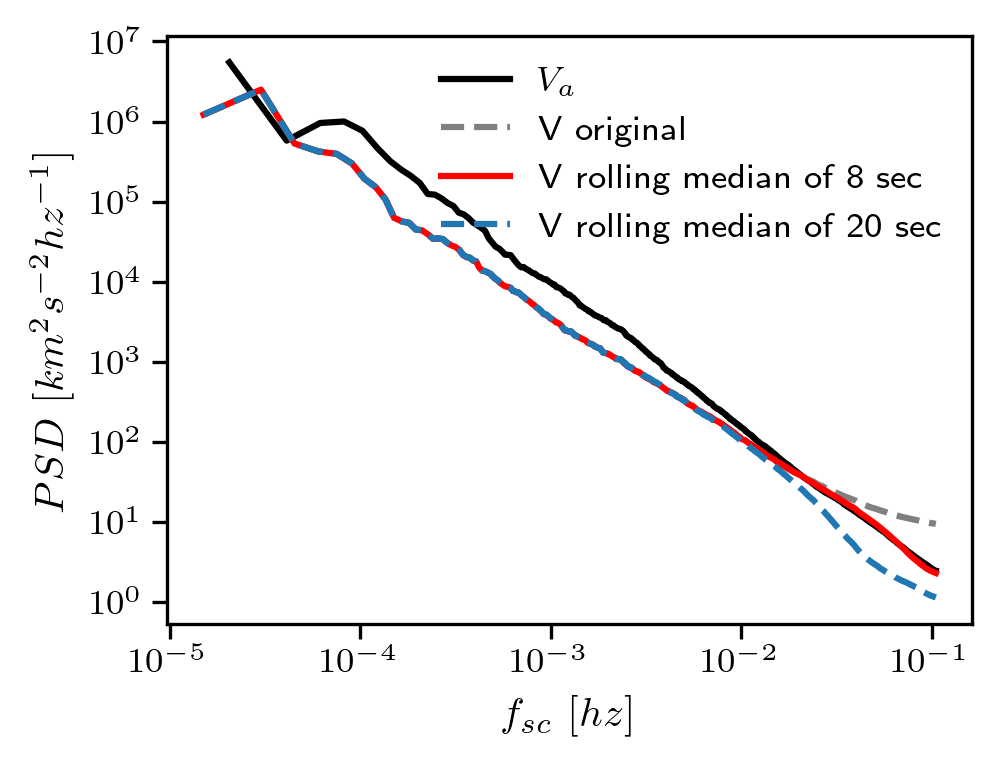

In [388]:
fig, ax =figs.initializeFigure('a', 'b')

#plt.loglog(sm_b_h[0], 12.5*sm_b_h[1])
plt.loglog(sm_b[0], sm_b[1]/3, c='k', label =r'$V_a$')

#plt.loglog(sm_b_h1[0], 12.5*sm_b_h1[1], c='k', ls='--')
plt.loglog(sm[0],sm[1], c='gray', ls='--', label ='V original')
plt.loglog(sm_8[0], sm_8[1], c='r' , label ='V rolling median of 8 sec')
plt.loglog(sm_12[0], sm_12[1], c='C0', ls='--' , label ='V rolling median of 20 sec')

# plt.loglog(sm_d1[0], sm_d1[1], c='k', ls='--')


plt.legend(frameon=0, fontsize='small')
plt.xlabel(r'$f_{sc} ~[hz]$')

plt.ylabel(r'$PSD ~[km^{2} s^{-2} hz^{-1} ]$')

In [65]:
#  Install these prerequisites once before executing the example code:
#  Option 1.
#    Install CDF from https://cdf.gsfc.nasa.gov/
#    pip install -U spacepy
#    pip install -U cdasws
#  Option 2.
#    pip install -U xarray
#    pip install -U cdflib
#    pip install -U cdasws

from cdasws import CdasWs
cdas = CdasWs()

#  Edit the following vars, time variables, and printing to suit your environment
# (spacepy or cdflib) and needs.
vars = ['Ne','Ne_peak','Ne_Quality']
time = ['1998-11-02 00:00', '1998-11-03 00:00',]
status, data = cdas.get_data('WI_H0_WAV', vars, time[0], time[1])

# If spacepy was installed
print(data['NE$'])
#print(data['Ne'].attrs)
#print(data)
#  ...
#  see https://spacepy.github.io/datamodel.html

# If xarray and cdflib was installed
#print(data.data_vars['Ne'].values)
#print(data.data_vars['Ne'].attrs)

#print(data)
#  ...
#  see https://github.com/MAVENSDC/cdflib


[ 7.51696  7.51696  7.51696 ... 11.5927  11.5927  11.5927 ]


In [66]:
plt.plot(data['Ne'])

KeyError: 'Ne'

In [67]:
dnp = np.nanmedian(np.array(data['NE$']*0.96)) - np.nanmedian(fin['Par']['V_resampled']['np'])

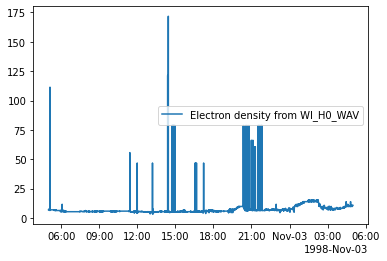

In [69]:
#fig, ax =figs.initializeFigure('a', 'b')

plt.xscale('linear')

#plt.plot(fin['Par']['V_resampled'].np+dnp, label = 'Proton density')
plt.plot(data['Epoch'], data['NE$']/1.08, label = 'Electron density from WI_H0_WAV' )
plt.legend()

### Check general info

In [72]:
gen

{'Start_Time': Timestamp('2018-11-01 00:00:00'),
 'End_Time': Timestamp('2018-11-01 23:59:59.790000'),
 'd': 1.0,
 'Fraction_missing_MAG': 0.0,
 'Fract_large_gaps': 0.705440957890441,
 'Resolution_MAG': 93.10009768535646,
 'part_flag': None,
 'qtn_flag': None,
 'Fraction_missing_part': 8.943351607008491,
 'Resolution_part': 3415.3435278215948,
 'sc': 'WIND'}

### Mag field gaps

This intervals has a lot of gaps!


In [73]:
mag_gaps 

,Start,End
0,2018-11-01 05:13:41.840,2018-11-01 05:20:08.332
1,2018-11-01 05:19:31.440,2018-11-01 07:40:35.531
2,2018-11-01 07:39:03.439,2018-11-01 07:53:46.731
3,2018-11-01 07:53:27.779,2018-11-01 08:05:25.931
4,2018-11-01 08:05:07.347,2018-11-01 08:10:20.423
5,2018-11-01 08:10:01.839,2018-11-01 08:16:46.730
6,2018-11-01 08:16:21.154,2018-11-01 08:31:11.530
7,2018-11-01 08:30:52.210,2018-11-01 09:10:26.730
8,2018-11-01 09:09:49.838,2018-11-01 09:29:09.130
9,2018-11-01 09:28:50.546,2018-11-01 09:56:45.130


### Check particle data

In [74]:
fin['Par'].keys()

dict_keys(['dict_psd', 'mean_sw_speed  ', 'median_sw_speed', 'std_sw_speed', 'median_alfv_speed', 'mean_alfv_speed', 'std_alfv_speed', 'median_MA_r', 'mean_MA_r', 'std_MA_r', 'beta_mean', 'beta_std', 'sigma_r_mean', 'sigma_r_median', 'sigma_r_std', 'sigma_c_median', 'sigma_c_mean', 'sigma_c_std', 'Vth_mean', 'Vth_std', 'Vsw_mean', 'Vsw_std', 'Np_mean', 'Np_std', 'di_mean', 'di_std', 'rho_ci_mean', 'rho_ci_std', 'VBangle_mean', 'VBangle_std', 'V_resampled'])

# Magnetic field timeseries

In [75]:
fin['Mag']['B_resampled']

,Br,Bt,Bn,Btot
Epoch,,,,
2018-10-31 23:59:58.874,NaN,NaN,NaN,NaN
2018-11-01 00:00:01.952,-4.029912,3.626310,1.854299,5.729825
2018-11-01 00:00:05.048,-4.012482,3.654009,1.843570,5.731592
2018-11-01 00:00:08.144,-4.038755,3.636977,1.847563,5.740543
2018-11-01 00:00:11.240,-4.085271,3.710239,1.823587,5.812221
...,...,...,...,...
2018-11-01 23:59:41.254,-2.766150,2.214558,-1.008395,3.683182
2018-11-01 23:59:44.350,-2.793847,2.244639,-0.821334,3.676783
2018-11-01 23:59:47.446,-2.798475,2.235275,-0.841385,3.679430


# Estimate resolution of Magnetic field timeseries:

In [76]:
func.find_cadence(fin['Mag']['B_resampled'])

3.3999088941361673

# Plot estimated power spectra for magnetc field

Don't be confused by R, T, N. Those are (x,y,z)

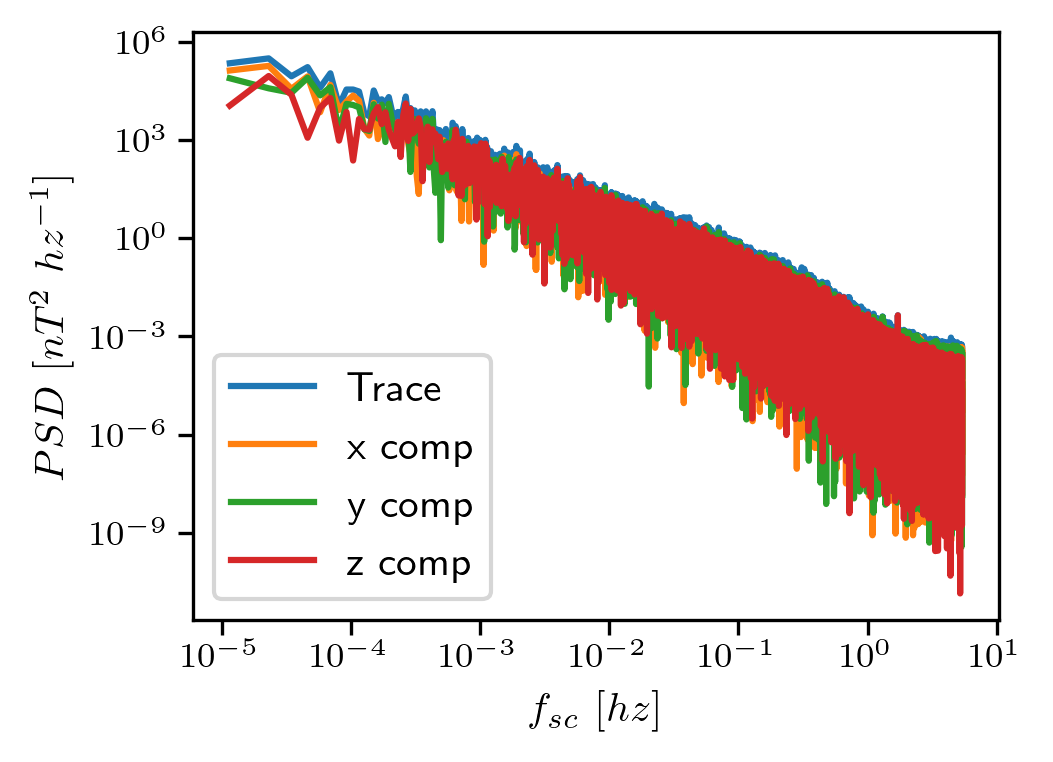

In [77]:
fig, ax =figs.initializeFigure(r'$PSD ~[nT^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig'], label ='Trace')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_R'], label ='x comp')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_T'], label ='y comp')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_N'], label ='z comp')

plt.legend()

# Particle timeseries

(a) Contains Vx, Vy, Vz [km/s], proton density [cm^-3], Proton temp [ev], Proton thermal speed [km/s]

In [78]:
fin['Par']['V_resampled']

,Vr,Vt,Vn,np,Tp,Vth
2018-10-31 23:59:58.874,-331.652466,-1.857373,10.215549,8.213666,3.175972,0.228980
2018-11-01 00:00:01.952,-331.652466,0.000000,10.215549,8.599883,3.305206,0.233592
2018-11-01 00:00:05.048,-331.652466,0.000000,10.215549,8.188411,3.331877,0.234533
2018-11-01 00:00:08.144,-333.273468,0.000000,11.198705,8.158342,3.301878,0.233475
2018-11-01 00:00:11.240,-333.273468,0.000000,11.198705,8.568443,3.278011,0.232629
...,...,...,...,...,...,...
2018-11-01 23:59:41.254,-347.300781,29.303211,-3.903457,6.571520,4.605794,0.275747
2018-11-01 23:59:44.350,-347.300781,29.303211,-3.903457,6.567027,4.689414,0.278239
2018-11-01 23:59:47.446,-345.546265,30.129732,-4.856009,6.598980,4.636713,0.276671
2018-11-01 23:59:50.541,-347.300781,29.303211,-4.879321,6.584585,4.382844,0.268991


# Plot estimated power spectra for several quantities

Don't be confused by R, T, N. Those are (x,y,z)

In [79]:
fin['Par']['dict_psd']

{'f_zpm': array([1.31411107e-05, 2.62822214e-05, 3.94233321e-05, ...,
        6.06068025e-02, 6.06199436e-02, 6.06330848e-02]),
 'psd_v': array([1.92119253e+10, 4.32266938e+06, 2.15933752e+06, ...,
        4.18447647e+01, 1.04306472e+01, 4.28854431e+01]),
 'psd_b': array([5.75739079e+05, 3.08213144e+06, 2.14264852e+06, ...,
        8.97516745e+00, 1.58079163e+01, 5.17862997e+00]),
 'psd_b_R': array([2.43163878e+04, 6.65745624e+05, 8.35666603e+05, ...,
        2.80592750e+00, 6.33702504e+00, 1.08155826e+00]),
 'psd_b_T': array([3.49828106e+05, 1.38657368e+05, 4.15555807e+05, ...,
        2.02248346e+00, 6.92402119e+00, 3.21741701e+00]),
 'psd_b_N': array([2.01594584e+05, 2.27772845e+06, 8.91426113e+05, ...,
        4.14675649e+00, 2.54687011e+00, 8.79654703e-01]),
 'psd_zp': array([1.83145080e+10, 7.14599686e+06, 4.10122960e+06, ...,
        9.03122010e+01, 3.26783168e+01, 6.35507531e+01]),
 'psd_zm': array([2.01413059e+10, 4.92672940e+06, 4.06198613e+06, ...,
        7.63133533e+01, 2.

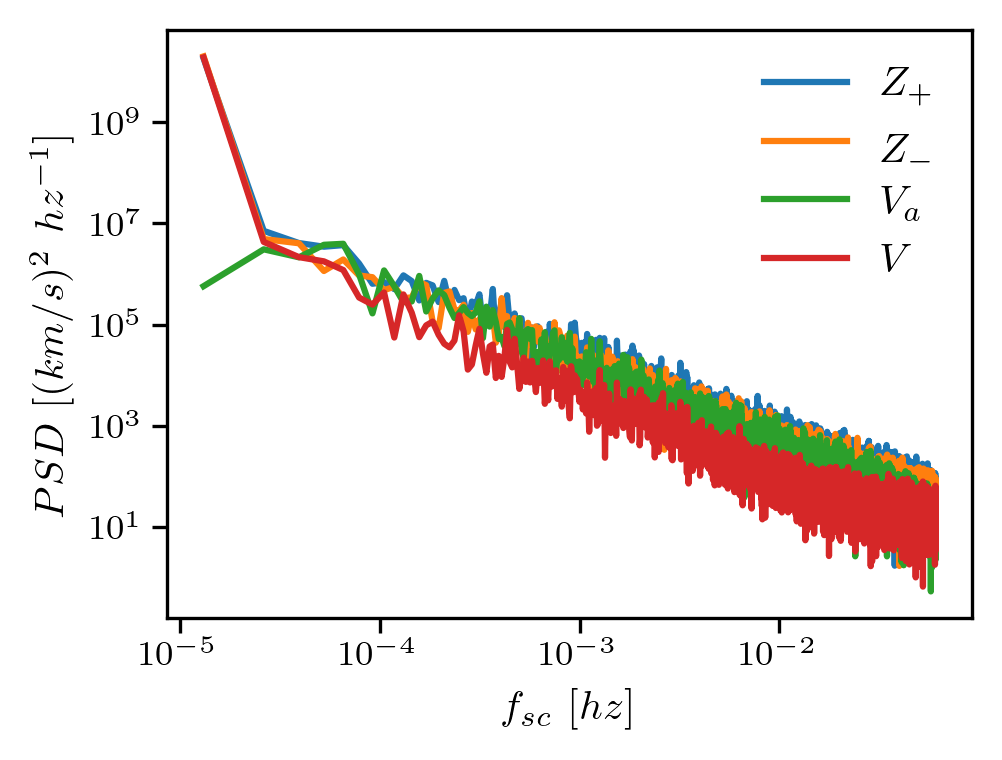

In [8]:
fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_zp'], label =r'$Z_{+}$')
plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_zm'], label =r'$Z_{-}$')

plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_b'], label =r'$V_a$')
plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'], label =r'$V$')
plt.legend(frameon=0)

# Plot cross heicity spectrum

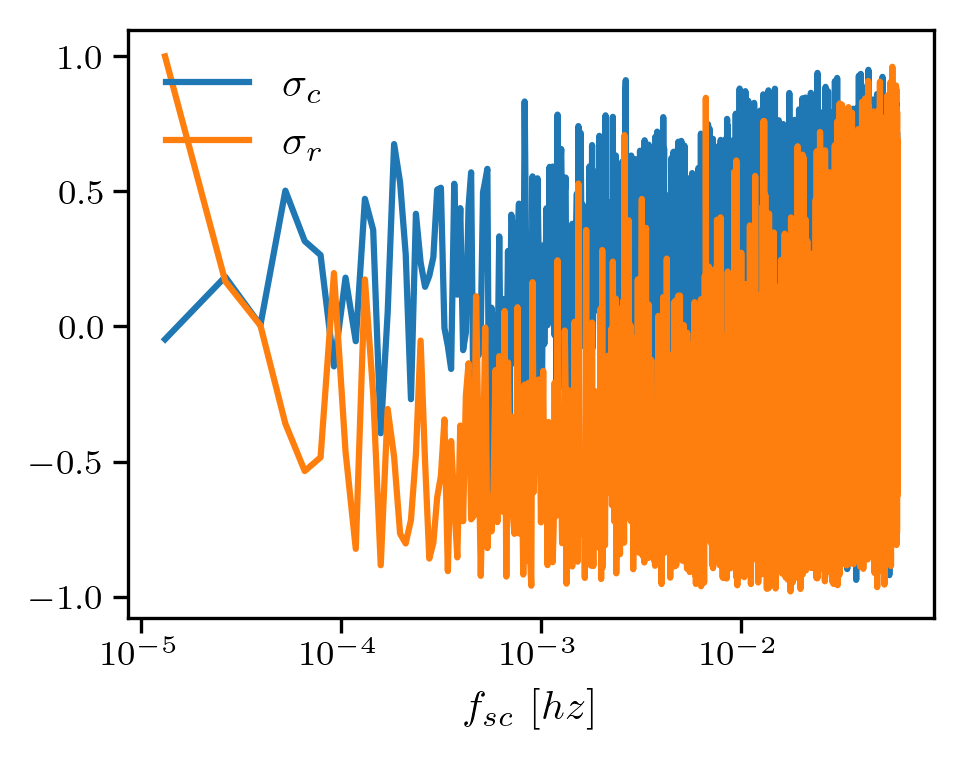

In [97]:
fig, ax =figs.initializeFigure(r'', r'$f_{sc} ~[hz]$')


zp = fin['Par']['dict_psd']['psd_zp']
zm = fin['Par']['dict_psd']['psd_zm']

va = fin['Par']['dict_psd']['psd_b']
v  = fin['Par']['dict_psd']['psd_v']

plt.yscale('linear')
plt.semilogx(fin['Par']['dict_psd']['f_zpm'], (zp-zm)/(zp+zm), label =r'$\sigma_c$')
plt.semilogx(fin['Par']['dict_psd']['f_zpm'], (v-va)/(v+va), label =r'$\sigma_r$')

plt.legend(frameon=0)

# You can also smooth the PSD

In [81]:
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])

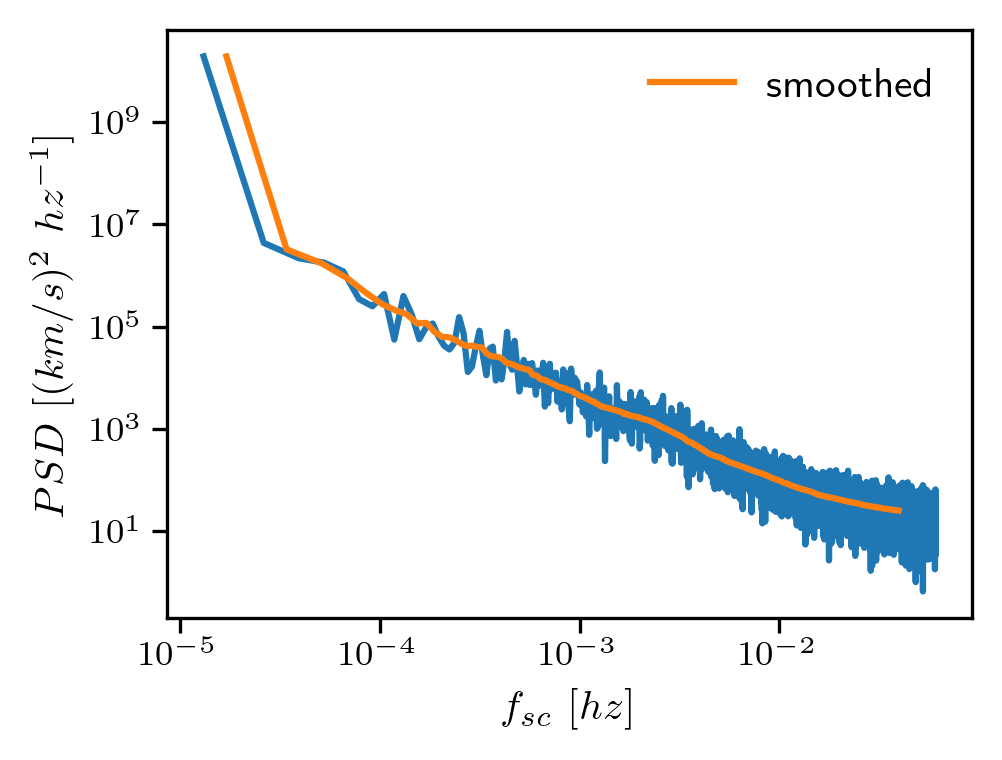

In [82]:
fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])

plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])
plt.loglog(sm[0], sm[1], label ='smoothed')
plt.legend(frameon=0)

# Fit the PSD

12-Feb-24 14:15:50: /var/folders/vj/mxbpcd0j13b_qfbqdq6h8b8r0000gs/T/ipykernel_65755/626478110.py:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-." (-> linestyle='-.'). The keyword argument will take precedence.
  plt.loglog(x[s:e],5*fit[2], 'k-.', lw=1.2, ls='-',label=lab_name)



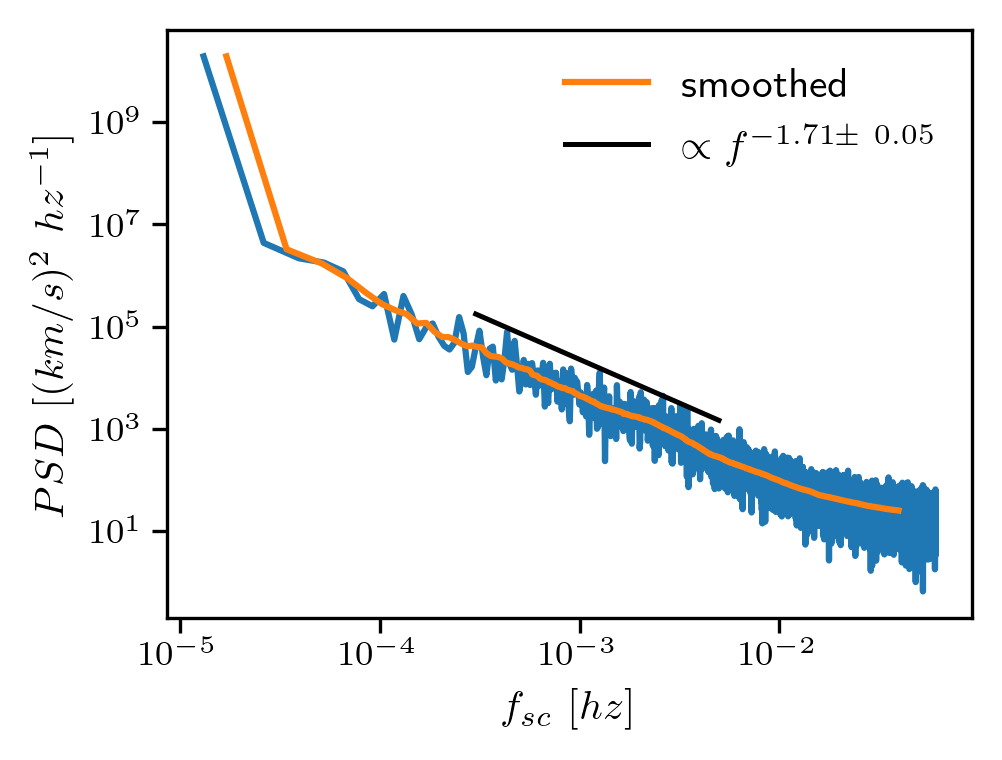

In [83]:
x0, xf = 3e-4, 5e-3

fit, s, e, x, y = func.find_fit(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'], x0, xf)

lab_name =r'$\propto f^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit[0][1],2), round(np.sqrt(fit[1][1][1]),2))


fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')

plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])
plt.loglog(sm[0], sm[1], label ='smoothed')


plt.loglog(x[s:e],5*fit[2], 'k-.', lw=1.2, ls='-',label=lab_name) 



plt.legend(frameon=0)

# Estimate resolution of Particle timeseries:

In [84]:
func.find_cadence(fin['Par']['V_resampled'])

3.0958097609918664

# Plot derived quantities

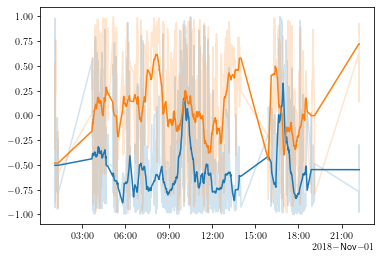

In [93]:
wind = '30min'

plt.plot(sig.sigma_r, c='C0', alpha=0.2)
plt.plot(sig.sigma_c,  c='C1', alpha=0.2)


# Smoothed version
plt.plot(sig.sigma_r.rolling(wind, center=True).mean().interpolate(), c='C0')
plt.plot(sig.sigma_c.rolling(wind, center=True).mean().interpolate(), c='C1')


# More derived quantities. To understand what those are look at /functions/calc_diagnostics.py

In [94]:
sig.keys()

Index(['dZpr', 'dZpt', 'dZpn', 'dZmr', 'dZmt', 'dZmn', 'dva_r', 'dva_t',
       'dva_n', 'dv_r', 'dv_t', 'dv_n', 'beta', 'np', 'Tp', 'VB', 'd_i', 'Ma',
       'Vsw', 'kin_norm', 'Ma_r_ts', 'sigma_c', 'Va', 'sigma_r'],
      dtype='object')